In [1]:
# Matrix Manipulation
import numpy as np
import pandas as pd

# Utility operations
from numpy import log as ln
import math
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Saving objects
import pickle

# Optimization
from functools import partial
from itertools import chain

# Utility Functions

In [2]:
class HDCModels():
    @classmethod
    def save_model(self, model, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_model(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class ItemMemories():
    @classmethod
    def save_IM(self, im, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(im, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_IM(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class SparseHDC():
    # Cyclic shifts the input hypervector arr by shift_count
    @classmethod
    def cyclic_shift(self, arr, shift_count=1):
        return np.concatenate((arr[-shift_count:],arr[:-shift_count]))
    
    @classmethod
    def dot(self, hv1, hv2):
        return np.sum(np.logical_and(hv1, hv2))
    
    @classmethod
    def disp(self, hv):
        s = math.sqrt(len(hv))
        if (s-int(s)):
            return "Must be square"
        
        return np.array(hv).reshape(int(s),int(s))

    # Generate a random sparse HV with dimension and sparsity
    @classmethod
    def generate_random_sparse_HV(self, dim = 10000, sparsity=0.3):
        percent_sparsity = int(100*sparsity)
        return np.vectorize(SparseHDC._generation_threshold)(np.random.randint(101,size=dim), percent_sparsity)
    
    # Generate count number of sparse HVs with dimension and sparsity
    @classmethod
    def generate_random_sparse_HVs(self, count=10, dim = 10000, sparsity=0.3):
        return [SparseHDC.generate_random_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate a sparse HV with exact sparsity
    @classmethod
    def generate_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        hv[random.sample(range(1,dim),int(sparsity*dim))]=1
        return hv
    
    # Generate count number of sparse HV with dimension and exact sparsity
    @classmethod
    def generate_sparse_HVs(self, count=10, dim=10000, sparsity=0.3):
        return [SparseHDC.generate_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # PRIVATE METHODS
    
    # Returns 1 if num < percent_sparsity where 0<=num<=100
    @classmethod
    def _generation_threshold(self, num, percent_sparsity = 30):
        return 1 if num<percent_sparsity else 0

# Datasets

In [3]:
class ISOLET():
    def __init__ (self, train_filepath = 'isolet1+2+3+4.csv', test_filepath = 'isolet5.csv'):
        self.train = pd.read_csv(train_filepath, header=None)
        self.train_X = self.train[[i for i in range(0,617)]]
        self.train_y = self.train[617]
        self.test = pd.read_csv(test_filepath, header=None)
        self.test_X = self.test[[i for i in range(0,617)]]
        self.test_y = self.test[617]
        
class ItemMemory():
    def __init__(self, cim, base_hvs):
        self.cim = cim
        self.base_hvs = base_hvs

# Continuous Item Memory Generators

In [4]:
class LinearCIM():
    def __init__(self, sparsity=0.3, dim=10000, seed=None):
        self.sparsity = sparsity
        self.dim = dim
        self.seed = seed
    
    def modify_specs(self, sparsity=None, dim=None):
        self.sparsity = sparsity if sparsity else self.sparsity
        self.dim = dim if dim else self.dim

    def generate(self, keys):
        if self.seed is None:
            seed = SparseHDC.generate_sparse_HV(sparsity=self.sparsity, dim=self.dim)
        else:
            seed = self.seed
        
        tracker = pd.Series(np.copy(seed))
        bit_step = int(np.sum(seed)/(len(keys)-1))
        hvs = [seed]

        for i in range(1,len(keys)):
            next_hv = np.copy(hvs[i-1])

            # TURN OFF K bits
            turnoff_index = random.sample(list(tracker[tracker==1].index), bit_step)
            tracker[turnoff_index]=-1 #Update to cannot be touched
            next_hv[turnoff_index]=0 #Turn them off from previous hv

            # TURN ON K bits
            turnon_index = random.sample(list(tracker[tracker==0].index), bit_step)
            tracker[turnon_index]=-1 #Update to cannot be touched
            next_hv[turnon_index]=1 #Turn them on

            hvs.append(next_hv)
            
        return dict(zip(keys,hvs))

# Sparsifiers

In [5]:
# Sparsifying Method

class ThresholdingSparsifier():
    def __init__(self, percent_max_val=0.3, max_val=617):
        self.percent_max_val = percent_max_val
        self.max_val = max_val
    
    def sparsify(self, hv):
        return np.array((hv>self.threshold())).astype(np.int)
    
    def threshold(self):
        return int(self.percent_max_val*self.max_val)

In [6]:
# END-TO-END

class HDC_Classifier():
    def __init__(self, encoder, ACC_THR = 125, training_data=ISOLET()):
        self.encoder = encoder
        self.data = training_data
        self.class_hvs = {}
        self.training_encoded = {}
        self.test_encoded = None
        self.ACC_THR = ACC_THR

    def train(self, save_encodes=True):      
        # Group rows by class
        classes = self.train_y().unique()
        class_rows = {}
        class_hvs = {}
        
        # Rows in each class
        class_indexes = {}
        for class_ in classes:
            class_indexes[class_] = list(self.train_y()[self.train_y()==class_].index)

        for class_ in classes:
            class_rows[class_] = np.array(list(self.train_X().loc[class_indexes[class_]].itertuples(index=False, name=None)))
        
        encoded = {}
        for class_ in classes:
            print("Encoding... {}% ".format(round(100*class_/classes[-1],2)))
            encoded[class_] = pd.Series(map(self.encoder.encode, class_rows[class_]))
        if save_encodes:
            self.training_encoded = encoded
        
        accumulated = np.array([np.sum(encoded[class_]) for class_ in classes])
        class_sparsifier = ThresholdingSparsifier(percent_max_val = self.ACC_THR/240, max_val=240)
        thresholded = pd.Series(map(class_sparsifier.sparsify, accumulated))
        thresholded.index = range(1,27)
        
        self.class_hvs = dict(thresholded)
        
        return "Done"
    
    def test(self):
        encoded_test = pd.Series(map(self.encoder.encode, np.array(self.test_X())))
        predictions = pd.Series(map(self.query, encoded_test))
        return np.sum(predictions == self.test_y())/len(self.test_y())

    # HELPER FUNCTIONS
    def query(self, query_hv):
        d = dict([[class_, SparseHDC.dot(class_hv, query_hv)] for class_,class_hv in self.class_hvs.items()])
        return max(d, key=d.get)
    
    def train_X(self):
        return self.data.train_X
    
    def train_y(self):
        return self.data.train_y
    
    def test_X(self):
        return self.data.test_X
    
    def test_y(self):
        return self.data.test_y

# MODEL DEVELOPMENT

### CONVERT NEXT THREE CELLS TO CODE AND RUN AS NEEDED

In [703]:
# RUN THIS ONCE

isolet = ISOLET()

# Rows in each class
class_indexes = {}
classes = range(1,27)
for class_ in classes:
    class_indexes[class_] = list(isolet.train_y[isolet.train_y==class_].index)

# Rows for each class
# class_rows[class_no][sample_no], class_no corresponds to A-Z but 1-26 instead
class_rows = {}
for class_ in classes:
    class_rows[class_] = np.array(list(isolet.train_X.loc[class_indexes[class_]].itertuples(index=False, name=None)))
    
# 10 rows for each class
test_class_rows = {}

for class_, rows in class_rows.items():
    test_class_rows[class_] = rows[0:10]

# TESTING

In [52]:
class HoloGNEncoder():
    def __init__(self, M, cim, sparsifier, feature_count=617, shifts=None):
        self.M = M
        self.qlevels = self.quantization_levels(M)
        self.cim = cim.generate(self.qlevels)
        self.sparsifier = sparsifier
        self.shifts = random.sample(range(0,feature_count),feature_count) if shifts is None else shifts
        
    def encode(self, features, return_accumulated=False):
        # Quantize
        quantized =  (map(self.get_level_hv, features))
        # Get the shifted versions
        shifted = pd.Series(map(SparseHDC.cyclic_shift, quantized, self.shifts))
        # Sum up the shifted versions
        acc = np.sum(shifted)
        # Sparsify
        sparse = self.sparsifier.sparsify(acc)
        return acc if return_accumulated else sparse
        

    def quantization_levels(self, M, min_val=-1, max_val=1, precision=5):
        step = (max_val - min_val) / (M-1)
        qlevels = list(np.arange(min_val, max_val+(0.1*step), step).round(precision))
        return qlevels

    def get_level_hv(self, value, index=False):
        closest_value = min(self.qlevels, key=lambda x:abs(x-value))
        return self.cim[closest_value]

In [832]:
enc_thresh = ThresholdingSparsifier(percent_max_val = 73/100, max_val=100)
acc_thresh = ThresholdingSparsifier(percent_max_val = 2/100, max_val=100)
hologn = HoloGNEncoder(10, LinearCIM(dim=10000, sparsity=0.10), sparsifier=enc_thresh)
hologn.cim = ItemMemories.load_IM('im_10k_sp0.10m10_r0.05.pkl').cim

# Generate samples
n = 9

A_acc = []
A = []
for i in range(0,n):
    A_acc.append(hologn.encode(test_class_rows[1][n], return_accumulated=True))
    A.append(hologn.sparsifier.sparsify(A_acc[i]))
    
B_acc = []
B = []
for i in range(0,n):
    B_acc.append(hologn.encode(test_class_rows[4][n], return_accumulated=True))
    B.append(hologn.sparsifier.sparsify(B_acc[i]))
    
[print(np.sum(a)) for a in B]

498
498
498
498
498
498
498
498
498


[None, None, None, None, None, None, None, None, None]

In [840]:
C_acc = []
C = []
for i in range(0,n):
    C_acc.append(hologn.encode(test_class_rows[3][n], return_accumulated=True))
    C.append(hologn.sparsifier.sparsify(C_acc[i]))

In [799]:
# im = ItemMemory(cim=hologn.cim, base_hvs=None)
# ItemMemories.save_IM(im=im, filename = 'im_10k_sp0.10m10_r0.003.pkl')

In [833]:
SparseHDC.dot(A[1],A[1])

533

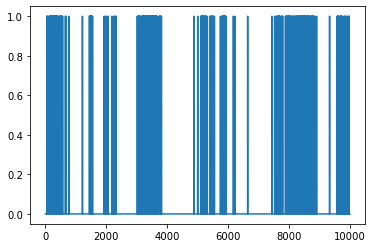

In [841]:
plt.plot(A[1])

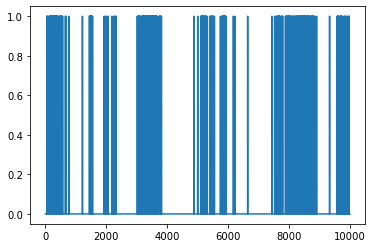

In [842]:
plt.plot(A[2])

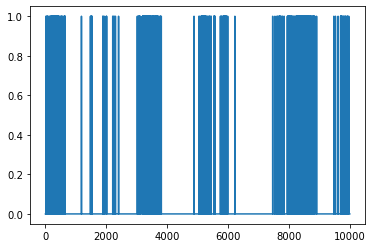

In [843]:
plt.plot(B[3])

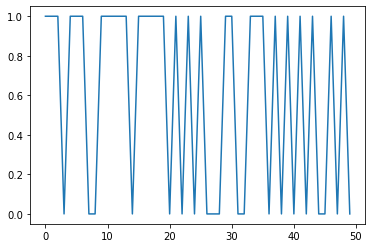

In [844]:
plt.plot(B[1][8475:8525])

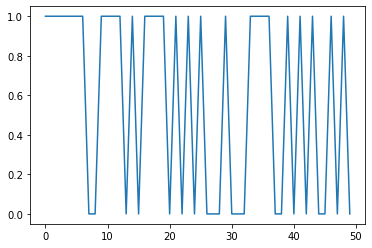

In [845]:
plt.plot(C[1][8475:8525])

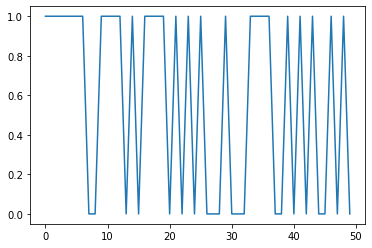

In [846]:
plt.plot(C[2][8475:8525])

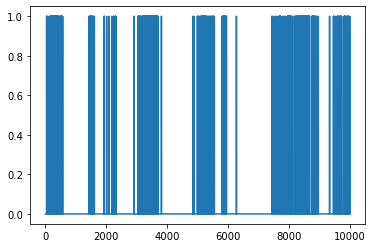

In [847]:
plt.plot(C[2])

In [806]:
np.sum(C[2])

14